In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import image
from PIL import Image
import threading
import time

# Classes

In [2]:
class FaceFinder:
    def __init__(self):
        self.img = None
        self.img_orig = None
        self.patches = []
        self.preds = None
        
    def process_photo(self, img_name, patch_size=64):
        self.img = plt.imread(img_name)
        self.img = scipy.misc.imresize(self.img, (self.img.shape[1], self.img.shape[1], self.img.shape[1]))
        self.img_orig = self.img.copy()
        
        self._split_pic_into_frames(size=patch_size)
        self._run_predictions()
        self._rectangify_patches()
        return self._gray_out()    
    
    def _split_pic_into_frames(self, size, stride=1/2):
        sh_x = self.img.shape[0]
        sh_y = self.img.shape[1]
        len_x = size
        len_y = size
        stride_x = np.ceil(len_x*stride).astype(int)
        stride_y = np.ceil(len_y*stride).astype(int)

        for y in range(0, sh_y, stride_y):
            for x in range(0, sh_x, stride_x):
                patch = self.img[y:y+len_y, x:x+len_x]
                if patch.shape[0]*patch.shape[1]!=0:
                    self.patches.append([patch, (x, y), (x+len_x, y+len_y)])
    
    def _rectangify_patches(self):
        columns = int(np.sqrt(len(self.preds)))
        
        cont = True
        while cont:
            cont = False
            for r in range(columns-1):
                for c in range(columns-1):
                    if self.preds[r*columns+c] == 0:
                        LD = self.preds[(r+1)*columns+c-1]
                        SD = self.preds[(r+1)*columns+c]
                        RD = self.preds[(r+1)*columns+c+1]
                        L = self.preds[r*columns+c-1]
                        R = self.preds[r*columns+c+1]
                        LG = self.preds[(r-1)*columns+c-1]
                        SG = self.preds[(r-1)*columns+c]
                        RG = self.preds[(r-1)*columns+c+1]

                        answ = L*LD*SD + SD*RD*R + R*RG*SG + SG*LG*L

                        if answ >= 1:
                            cont = True
                            self.preds[r*columns+c] = 1
    
    def _gray_out(self):
        coord_start = np.array(self.patches)[:, 1]
        coord_end = np.array(self.patches)[:, 2]

        self.img.setflags(write=1)

        for start, end, pred in zip(coord_start, coord_end, self.preds):
            R = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 0]
            G = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 1]
            B = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 2]
            self.img[start[0]:end[0], start[1]:end[1]][:, :, 0] = np.array(R*pred).astype(np.uint8)
            self.img[start[0]:end[0], start[1]:end[1]][:, :, 1] = np.array(G*pred).astype(np.uint8)
            self.img[start[0]:end[0], start[1]:end[1]][:, :, 2] = np.array(B*pred).astype(np.uint8)
            
        return self.img, self.img_orig
            
    def _run_predictions(self, sess):
        a = [scipy.misc.imresize(i[0], shape) for i in self.patches]
        self.preds = sess.run(ar_max, feed_dict={features: a, labels: y[:len(a)]})

In [3]:
class DataGenerator:
    def __init__(self, coord, features, max_queue_size=3):
        self.threads = []
        self.coord = coord
        self.max_queue_size = max_queue_size
        self.features = self._numpify_features(features)
        
        self.queue = tf.FIFOQueue(capacity=max_queue_size, dtypes=tf.float32)
        self.queue_size = self.queue.size()
        
        self.sample_placeholder = tf.placeholder(dtype=tf.float32, shape=None)
        self.enqueue = self.queue.enqueue([self.sample_placeholder])
        
    def _numpify_features(self, features):
        if type(features) is not np.ndarray:
            return np.array(features)
        return features
        
    def dequeue(self):
        return self.queue.dequeue()
    
    def thread_main(self, sess, thread_num, batches_num, batch_size, last_batch):
        iterator = self._load_data(thread_num, batches_num, batch_size, last_batch)
        
        for data in iterator:
            while self.queue_size.eval(session=sess) == self.max_queue_size:
                if self.coord.should_stop():
                    break
                time.sleep(0.01)
            if self.coord.should_stop():
                break  
            sess.run(self.enqueue, feed_dict={self.sample_placeholder: data})

                
    def start_threads(self, sess, n_threads, batch_size):
        batches_per_thread = int(self.features.shape[0]/batch_size/n_threads)
        
        for i in range(n_threads):
            last_batch = (i == n_threads-1)
            
            thread_args = (sess, i, batches_per_thread, batch_size, last_batch)
            thread = threading.Thread(target=self.thread_main, args=thread_args)
            thread.daemon = True
            thread.start()
            
            self.threads.append(thread)
            
        return self.threads
    
    def _load_data(self, thread_num, batches_num, batch_size, last_batch):
        i_start = thread_num*batches_num
        i_end = i_start+batches_num
        if last_batch:
            i_end += batches_num

        for i in range(i_start, i_end):
            yield self.features[i*batch_size : (i+1)*batch_size]

# Queue playground (TBD)

In [4]:
def load_data(features, thread_num, batches_num, batch_size, last_batch):
    i_start = thread_num*batches_num
    i_end = i_start+batches_num
    if last_batch:
        i_end += batches_num
        
    for i in range(i_start, i_end):
        yield features[i*batch_size : (i+1)*batch_size]

In [9]:
features = np.random.rand(1024, 64, 64, 3)

batch_size = 64

coord = tf.train.Coordinator()
reader = DataGenerator(coord, features, 5)

net = reader.dequeue()

counter = 0

with tf.Session() as sess:
    init = [tf.global_variables_initializer(), tf.local_variables_initializer()]
    sess.run(init)

    threads = reader.start_threads(sess, 5, batch_size)

    while not counter==len(features):
        time.sleep(0.05)
        counter+=sess.run(net).shape[0]
    
    coord.request_stop()
    print(counter)
    
    for thread in threads:
        thread.join()

1024


# Model variables

In [59]:
epochs = 5
shape = (64, 64, 3)

## Prepare data

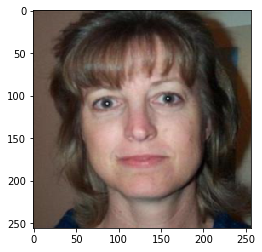

In [60]:
with open('Faces/files_list.txt') as f:
    face_files_list = f.readlines()
    
face_list = [i.strip() for i in face_files_list] 
faces = [plt.imread(i) for i in face_list]
faces = [scipy.misc.imresize(i, (256, 256, 3)) for i in faces]
plt.imshow(faces[int(np.random.random(1)*len(faces))])

In [61]:
def split_pic(img):
    face = []
    background = []
    
    shape = 256
    
    length = 64 
    stride = 64
    
    for y in range(0, shape, stride):
        for x in range(0, shape, stride):
            patch = img[y:y+length, x:x+length]
            if y>=64 and y+length<=192 and x>=64 and x+length<=192:
                face.append(patch)
            else:
                background.append(patch)
    face.append(scipy.misc.imresize(img[64:128, 64:128], (64, 64, 3)))
    
    return face, background

In [62]:
face = []
background = []
for i in faces:
    f, b = split_pic(i)
    face.append(f)
    background.append(b)
    
background = np.array(background).reshape(435*12, 64, 64, 3)
face = np.array(face).reshape(435*5, 64, 64, 3)

print("%i : %i" % (len(face), len(background)))

2175 : 5220


In [63]:
X = np.concatenate([face, background]).astype(np.float32)
y = [[1] for i in range(len(face))]
y.extend([[0] for i in range(len(background))])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

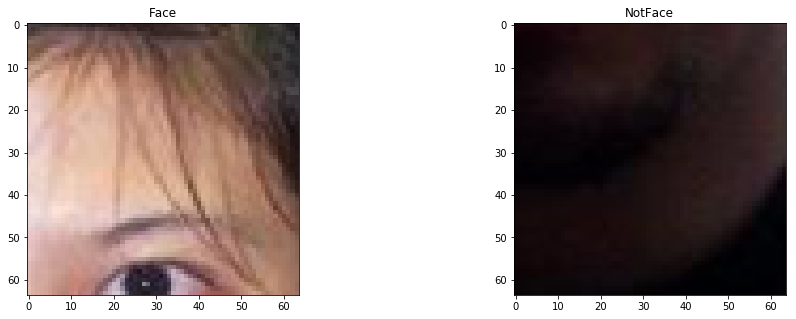

In [64]:
x1 = face[int(np.random.random(1)*len(face))]
x2 = background[int(np.random.random(1)*len(background))]

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(x1)
plt.title('Face');

plt.subplot(122)
plt.imshow(x2)
plt.title('NotFace');

# Craft and fit model

In [ ]:
def split(features, labels, batch_size):
    for i in range(0, len(features), batch_size):
        yield (features[i:i+batch_size], labels[i:i+batch_size])

In [ ]:
def queuer(features, labels, batch_size):
    i = queuer.iter
    queuer.iter += batch_size
    return tf.convert_to_tensor(features[i:i+batch_size])

queuer.iter=0

In [ ]:
q = tf.FIFOQueue(capacity=5, dtypes=tf.float32)
q.enqueue(queuer(X_train, y_train, 64))

In [ ]:
q = tf.FIFOQueue(capacity=5, dtypes=tf.float32)
q.enqueue(queuer(X_train, y_train, 64))

a = tf.constant([1.0, 3.0])

a = tf.Print(a, [q.dequeue()], message='test: ')

b = tf.add(a, a)
with tf.Session() as sess:
    print(sess.run(b))

In [ ]:
print('dupa')

In [ ]:
tf.reset_default_graph()
base_graph = tf.Graph()

with tf.variable_scope("placeholders"):
    features = tf.placeholder(tf.float32, shape=[None, shape[0], shape[1], shape[2]])
    labels = tf.placeholder(tf.int32, shape=[None, 1])
    
q = tf.FIFOQueue(capacity=5, dtypes=tf.float32)
q.enqueue(queuer(X_train, y_train, 64))
    
# ARCHITECTURE
with tf.variable_scope("convolutional"):
    input_layer = tf.reshape(q.dequeue(), [-1, shape[0], shape[1], shape[2]])

    conv1 = tf.layers.conv2d(
                inputs=input_layer,
                filters=32,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

    conv2 = tf.layers.conv2d(
                inputs=pool1,
                filters=32,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)

    conv3 = tf.layers.conv2d(
                inputs=pool2,
                filters=64,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)   
    flatten = tf.reshape(pool3, [-1, int((shape[0]/8)*(shape[1]/8)*64)])  

with tf.variable_scope("dense"):
    dense1 = tf.layers.dense(
                inputs=flatten,
                units=512)
    dense1_batch = tf.layers.batch_normalization(dense1, training=True)
    dense1_relu = tf.nn.relu(dense1_batch)

    dense2 = tf.layers.dense(
                inputs=dense1_relu,
                units=256,
                activation=tf.nn.relu)

    dense3 = tf.layers.dense(
                inputs=dense2,
                units=128)
    dense3_batch = tf.layers.batch_normalization(dense3, training=True)
    dense3_relu = tf.nn.relu(dense3_batch)

    dense4 = tf.layers.dense(
                inputs=dense3_relu,
                units=64,
                activation=tf.nn.relu)

with tf.variable_scope("logits"):
    logits = tf.layers.dense(inputs=dense4, units=2)

with tf.variable_scope("output"):
    ar_max = tf.argmax(input=logits, axis=1)
    predictions = {
        'classes': ar_max,
        'probabilities': tf.nn.softmax(logits)
    }

# EVALUATION output point
accuracy = tf.metrics.accuracy(labels=labels, predictions=ar_max)
# confusion = tf.confusion_matrix(labels[:, 1], ar_max)

# TRAINING output point
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
train_op = tf.train.AdamOptimizer().minimize(loss=loss, global_step=tf.train.get_global_step())

In [ ]:
# sess.close()

sess = tf.Session()
init = [tf.global_variables_initializer(), tf.local_variables_initializer()]
sess.run(init)

for batch in split(X_test, y_test, 64):
    opt, acc_test = sess.run((loss, accuracy[1]), feed_dict={features: batch[0], labels: batch[1]})
    
print('Loss: %.5f, Test acc: %d%%' % (opt, acc_test*100))


for step in range(7):
    for batch in split(X_train, y_train, 64):
        feed_dict = { features: batch[0], labels: batch[1]}
        sess.run(train_op, feed_dict=feed_dict)

    for batch in split(X_test, y_test, 64):
        opt, acc_test = sess.run((loss, accuracy[1]), feed_dict={features: batch[0], labels: batch[1]})
    print('Loss: %.5f, Test acc: %d%%' % (opt, acc_test*100))

In [ ]:
writer = tf.summary.FileWriter('logs', sess.graph)
print(sess.run(logits, feed_dict={features: [X[0]], labels: [y[0]]}))
writer.close()

In [ ]:
# predictions = sess.run(ar_max, feed_dict={features: X, labels: y})

# conf = confusion_matrix(y, predictions)
# print(conf)



# Wrongly classified examples

In [ ]:
for i, j, k in zip(predictions, y, X):
    if i != j:
        k = k.astype(np.uint8)
        plt.figure()
        plt.imshow(k)

# Face location

In [ ]:
np.sqrt(2)

In [ ]:
facefinder = FaceFinder()
img, img_orig = facefinder.process_photo('lfw/Howard_Stringer/Howard_Stringer_0001.jpg', patch_size=32)

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(img_orig)
plt.subplot(122)
plt.imshow(img)

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
frozen_graph = freeze_session(keras.backend.get_session(), output_names=[model.output.op.name])

In [ ]:
tf.train.write_graph(frozen_graph, "frozen_model", "model.pb", as_text=False)

checkpoint = tf.train.get_checkpoint_state('./frozen/')
input_checkpoint = checkpoint.model_checkpoint_path

absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
output_graph = absolute_model_dir + "/frozen_model.pb"

clear_devices = True

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    saver.restore(sess, input_checkpoint)

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        ['activation_7/Softmax']
    ) 

    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))